# Importing the relevant Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau
import pickle
from keras import backend as K

import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Connecting to the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf. __version__)

2.15.0


# Explority Data Analysis

## Setting the path to the location of the dataset

In [ ]:

path = "/content/drive/MyDrive/plantdetection/PlantVillage"
print (path)

/content/drive/MyDrive/plantdetection/PlantVillage


## Viewing the images from each directory

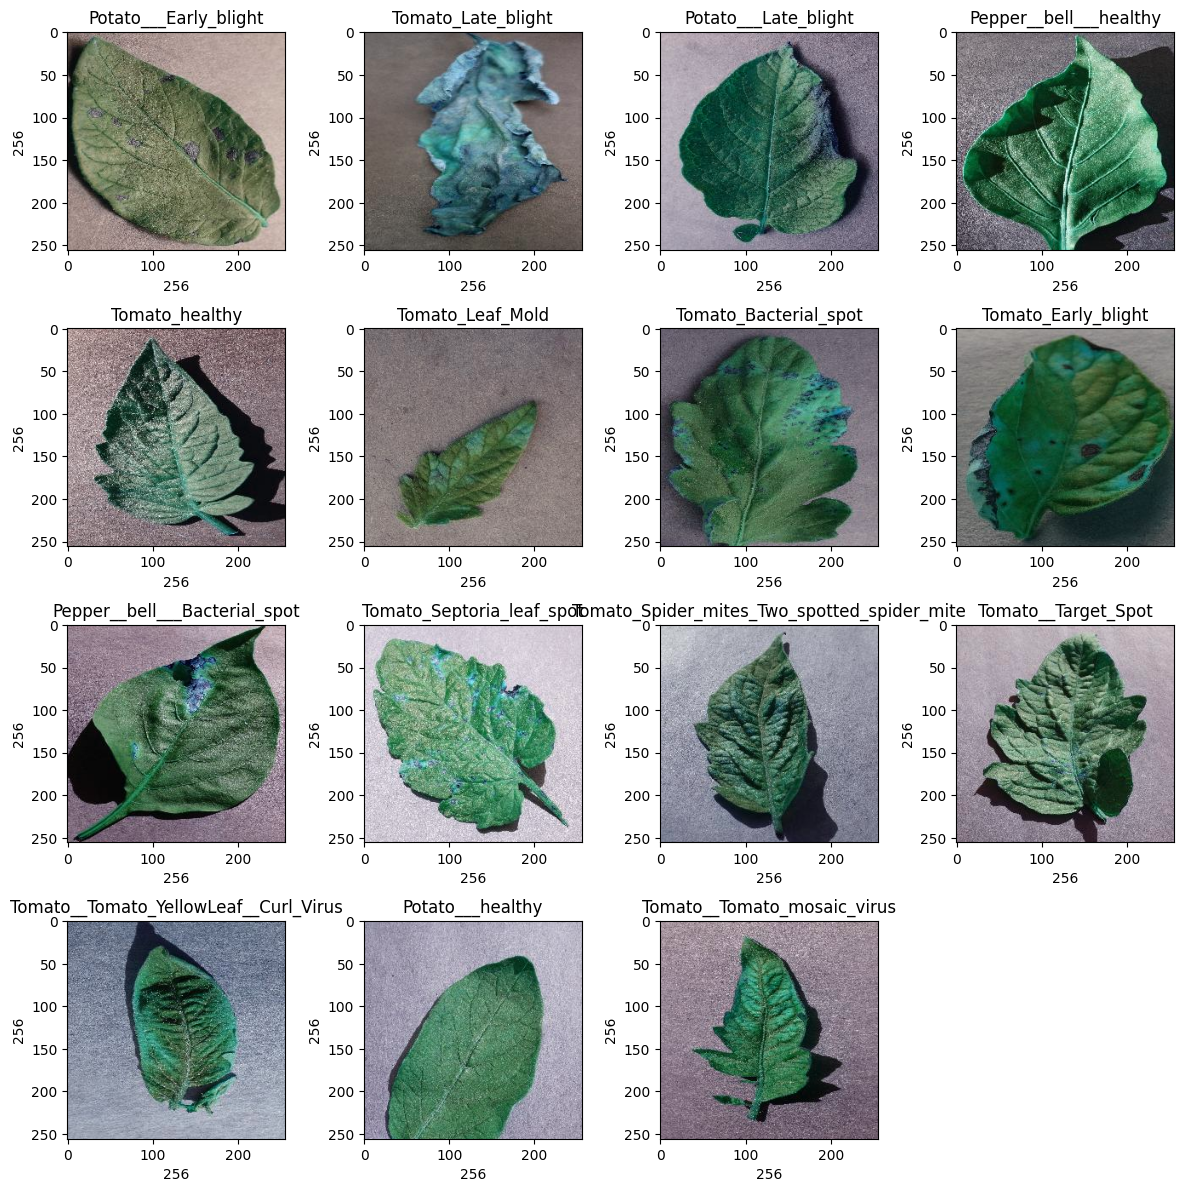

In [ ]:
def read_resize_images():
  pos = 1
  image_list = []
  img_title = []
  for x in os.listdir(path):
    image_path = os.path.join(path,x)
    img_title.append(x)
    pos = pos + 1
    for y in os.listdir(image_path):
      image_portray = cv2.imread(os.path.join(image_path, y), cv2.IMREAD_UNCHANGED)
      image_list.append(image_portray)
      break
  plt.figure(figsize=(12,12))
  for i in range(0,len(image_list)):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.title(img_title[i])
    plt.imshow(image_list[i])
    plt.xlabel(image_list[i].shape[1], fontsize = 10)
    plt.ylabel(image_list[i].shape[0], fontsize = 10)
read_resize_images()


## Function to Convert images to array and Resize images to 256,256. And Setting a dataframe for converted images.


In [ ]:
def image_to_array(directory):
  img = cv2.imread(directory)
  if img is not None:
    img = cv2.resize(img, (256,256))
    return img_to_array(img)
  else:
    return np.array([])

In [ ]:

img_list = []
img_label_list = []

try:
    list_of_dir = os.listdir(path)
    for direct in list_of_dir:
      image_file = os.listdir(path + "/" + direct)

      for imgs in image_file[:300]:
        img_path = (path + '/' + direct + '/' + imgs)
        if img_path.endswith('jpg') == True or img_path.endswith('JPG') == True:
          img_list.append(image_to_array(img_path))
          img_label_list.append(direct)

except Exception as e:
    print('error' + e)




df_img = pd.DataFrame({'image_root':img_list, 'label':img_label_list})
df_img.head(10)






,image_root,label
0,"[[[114.0, 97.0, 94.0], [143.0, 126.0, 123.0], ...",Potato___Early_blight
1,"[[[169.0, 158.0, 160.0], [187.0, 176.0, 178.0]...",Potato___Early_blight
2,"[[[127.0, 120.0, 123.0], [165.0, 158.0, 161.0]...",Potato___Early_blight
3,"[[[190.0, 177.0, 179.0], [190.0, 177.0, 179.0]...",Potato___Early_blight
4,"[[[154.0, 140.0, 144.0], [129.0, 115.0, 119.0]...",Potato___Early_blight
5,"[[[174.0, 173.0, 183.0], [178.0, 177.0, 187.0]...",Potato___Early_blight
6,"[[[171.0, 157.0, 158.0], [170.0, 156.0, 157.0]...",Potato___Early_blight
7,"[[[143.0, 139.0, 150.0], [143.0, 139.0, 150.0]...",Potato___Early_blight
8,"[[[169.0, 162.0, 169.0], [170.0, 163.0, 170.0]...",Potato___Early_blight
9,"[[[185.0, 180.0, 182.0], [184.0, 179.0, 181.0]...",Potato___Early_blight


## Viewing The value count to check if there is imbalancement

In [ ]:
df_img['label'].value_counts()

label
Potato___Early_blight                          300
Tomato_Late_blight                             300
Potato___Late_blight                           300
Pepper__bell___healthy                         300
Tomato_healthy                                 300
Tomato_Leaf_Mold                               300
Tomato_Bacterial_spot                          300
Tomato_Early_blight                            300
Pepper__bell___Bacterial_spot                  300
Tomato_Septoria_leaf_spot                      300
Tomato_Spider_mites_Two_spotted_spider_mite    300
Tomato__Target_Spot                            300
Tomato__Tomato_YellowLeaf__Curl_Virus          300
Tomato__Tomato_mosaic_virus                    300
Potato___healthy                               152
Name: count, dtype: int64

## Viewing the Data types, to make sure they are all the same type

In [ ]:
df_img.dtypes

image_root    object
label         object
dtype: object

## Checking for missing values

In [ ]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_root  4352 non-null   object
 1   label       4352 non-null   object
dtypes: object(2)
memory usage: 68.1+ KB


## Viewing the last 5 elements of the dataset

In [ ]:
df_img.tail()

,image_root,label
4347,"[[[159.0, 139.0, 152.0], [162.0, 142.0, 155.0]...",Tomato__Tomato_mosaic_virus
4348,"[[[122.0, 112.0, 125.0], [122.0, 112.0, 125.0]...",Tomato__Tomato_mosaic_virus
4349,"[[[151.0, 139.0, 157.0], [133.0, 121.0, 139.0]...",Tomato__Tomato_mosaic_virus
4350,"[[[112.0, 90.0, 95.0], [142.0, 120.0, 125.0], ...",Tomato__Tomato_mosaic_virus
4351,"[[[160.0, 146.0, 152.0], [126.0, 112.0, 118.0]...",Tomato__Tomato_mosaic_virus


## Viewing the shape of the Dataset

In [ ]:
df_img.shape

(4352, 2)

## Plotting the count for each class of the dataset and visualising the data to understand it


<Axes: xlabel='label', ylabel='count'>

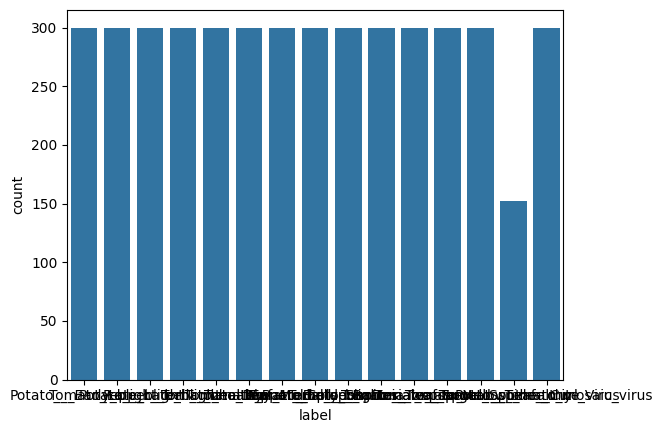

In [ ]:
plt.figure()
sns.countplot(data=df_img, x="label")

<Axes: ylabel='count'>

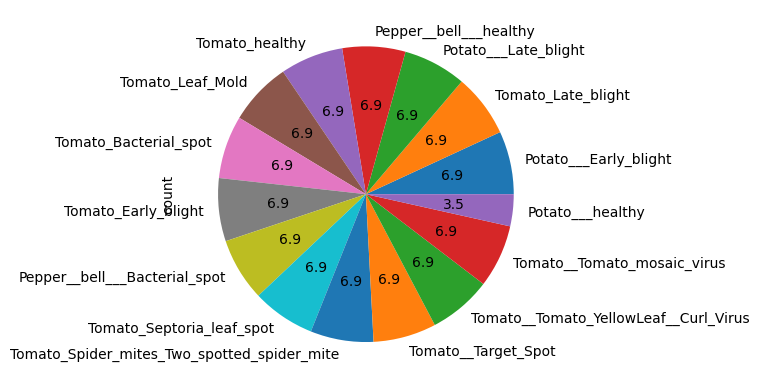

In [ ]:
df_img['label'].value_counts().plot.pie(autopct='%.1f')

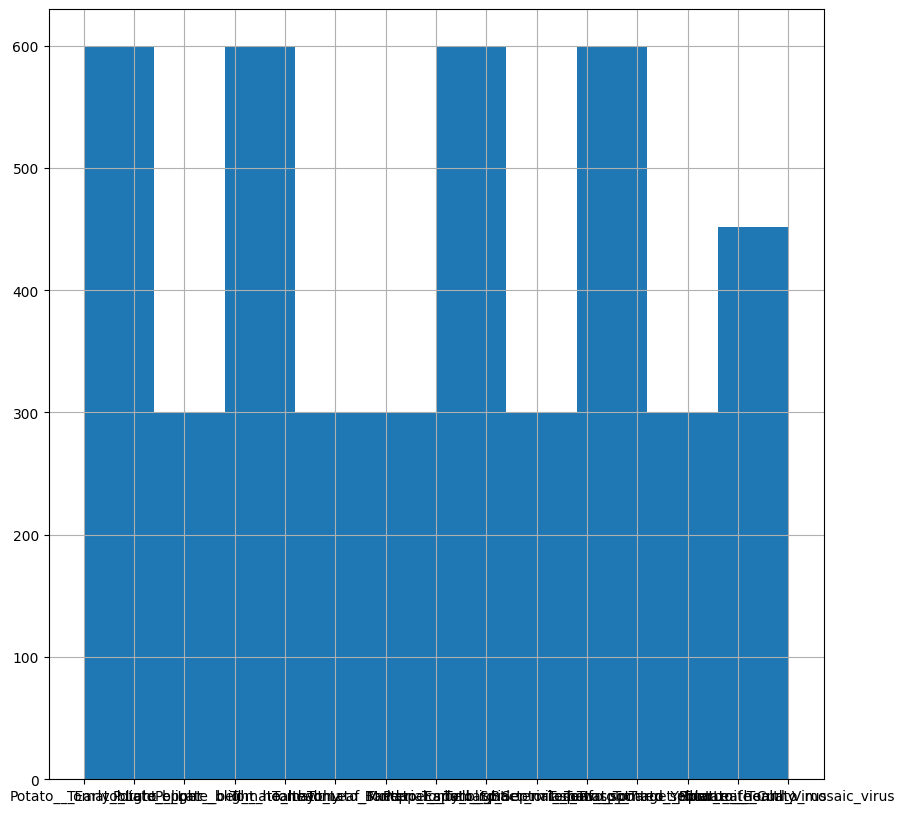

In [ ]:
df_img['label'].hist(figsize=(10,10))
plt.show()

<Axes: xlabel='label'>

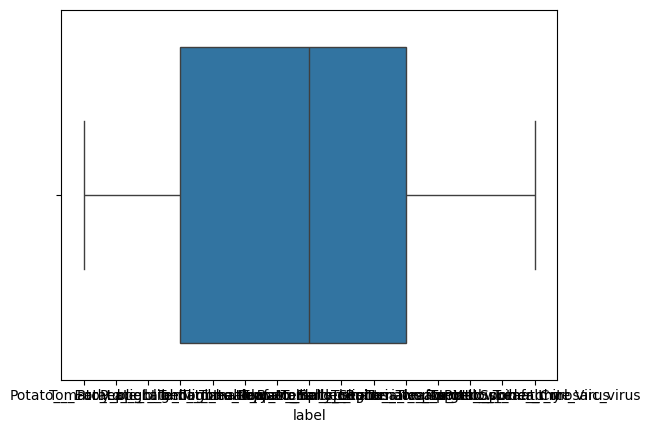

In [ ]:
sns.boxplot(x=df_img['label'], orient='h')

## Checking for missing values


In [ ]:
df_img.isnull().sum()

image_root    0
label         0
dtype: int64

In [ ]:

print(img_label_list[0])
for index, x in enumerate(img_label_list):
  if x == 'Pepper__bell___Bacterial_spot':
    break
print(x)
print(index)
print(img_label_list[2527])

Potato___Early_blight
Pepper__bell___Bacterial_spot
2400
Pepper__bell___Bacterial_spot


## Converting the Labels to Binary and viewing the changes made



In [ ]:
lb = LabelBinarizer()
img_label_list_binary = lb.fit_transform(img_label_list)
pickle.dump(lb,open('label_transform.pkl', 'wb'))
print(lb.classes_)


['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
print(img_label_list_binary)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
print(img_label_list)

['Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight',

## Seeing the value counts of the converted Labels

In [ ]:
count = pd.DataFrame(img_label_list_binary).value_counts()
count.head()

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14
0  0  0  0  0  0  0  0  0  0  0   0   0   0   1     300
                                          1   0     300
                                      1   0   0     300
                                  1   0   0   0     300
                              1   0   0   0   0     300
Name: count, dtype: int64

## Normalizing the data to 0,1 and visualising it

In [ ]:
img_list_array = np.array(img_list, dtype=np.float16) / 255.0

In [ ]:
print(img_list_array)

[[[[0.447  0.3804 0.3687]
   [0.5605 0.4941 0.4824]
   [0.5845 0.5176 0.506 ]
   ...
   [0.7373 0.6626 0.6313]
   [0.745  0.6704 0.639 ]
   [0.753  0.678  0.647 ]]

  [[0.533  0.4666 0.4548]
   [0.4902 0.4236 0.4119]
   [0.5293 0.4626 0.451 ]
   ...
   [0.7646 0.6904 0.6587]
   [0.7607 0.686  0.655 ]
   [0.757  0.682  0.651 ]]

  [[0.506  0.4392 0.4275]
   [0.4626 0.396  0.3843]
   [0.6353 0.569  0.5566]
   ...
   [0.757  0.682  0.651 ]
   [0.741  0.6665 0.6353]
   [0.7334 0.6587 0.6274]]

  ...

  [[0.6626 0.5845 0.565 ]
   [0.639  0.5605 0.541 ]
   [0.6313 0.5527 0.533 ]
   ...
   [0.796  0.7217 0.6904]
   [0.8037 0.7295 0.698 ]
   [0.8115 0.7373 0.706 ]]

  [[0.6313 0.5527 0.533 ]
   [0.5884 0.51   0.4902]
   [0.612  0.533  0.5137]
   ...
   [0.8076 0.7334 0.702 ]
   [0.8037 0.7295 0.698 ]
   [0.8037 0.7295 0.698 ]]

  [[0.5845 0.506  0.4863]
   [0.545  0.4666 0.447 ]
   [0.604  0.5254 0.506 ]
   ...
   [0.784  0.71   0.678 ]
   [0.7764 0.702  0.6704]
   [0.7686 0.6943 0.6626]]]


 

## Splitting the dataset and viewing the splitted sets shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_list_array, img_label_list_binary, test_size=0.20, random_state=42)

In [ ]:
X_train.shape

(3481, 256, 256, 3)

In [ ]:
X_test.shape

(871, 256, 256, 3)

In [ ]:
y_train.shape

(3481, 15)

In [ ]:
y_test.shape

(871, 15)

## Implementing Data augumentation

In [ ]:
imagedatagenerator = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

# Implemntation of the Model

## Creating the layers of the DenseNet24 Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3)))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(lb.classes_)))
model.add(Activation("softmax"))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 85, 85, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 85, 85, 64)        18496     
                                                                 
 activation_15 (Activation)  (None, 85, 85, 64)        0         
                                                      

## Compiling the model

In [ ]:
model.compile(loss="binary_crossentropy", optimizer = Adam(0.0001), metrics=['accuracy'])

## Fitting the Model

In [ ]:

history = model.fit(X_train,y_train, batch_size=128, epochs=1000, validation_data=(X_test, y_test))

Epoch 1/1000
28/28 [==============================] - 10s 267ms/step - loss: 0.7379 - accuracy: 0.1692 - val_loss: 0.6804 - val_accuracy: 0.0792
Epoch 2/1000
28/28 [==============================] - 6s 209ms/step - loss: 0.6681 - accuracy: 0.3123 - val_loss: 0.6664 - val_accuracy: 0.1137
Epoch 3/1000
28/28 [==============================] - 6s 209ms/step - loss: 0.6419 - accuracy: 0.4433 - val_loss: 0.6476 - val_accuracy: 0.1470
Epoch 4/1000
28/28 [==============================] - 6s 210ms/step - loss: 0.6149 - accuracy: 0.5108 - val_loss: 0.6233 - val_accuracy: 0.1389
Epoch 5/1000
28/28 [==============================] - 6s 211ms/step - loss: 0.5824 - accuracy: 0.5579 - val_loss: 0.5912 - val_accuracy: 0.2204
Epoch 6/1000
28/28 [==============================] - 6s 211ms/step - loss: 0.5420 - accuracy: 0.6056 - val_loss: 0.5521 - val_accuracy: 0.2537
Epoch 7/1000
28/28 [==============================] - 6s 211ms/step - loss: 0.4975 - accuracy: 0.6357 - val_loss: 0.5101 - val_accuracy

# Model Evaluation

## Accuracy of the model

In [ ]:
scores = model.evaluate(X_test, y_test)
print("Test accuracy: ", scores[1])

28/28 [==============================] - 2s 30ms/step - loss: 0.0912 - accuracy: 0.8760
Test accuracy:  0.8760045766830444


## Using the model to make predictions

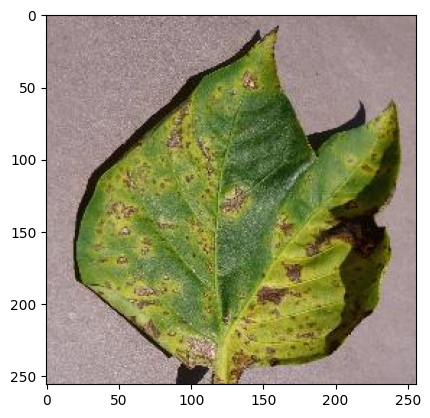

In [ ]:
imagepath = imread("/content/drive/MyDrive/plantdetection/01dfb88b-cd5a-420c-b163-51f5fe07b74d___JR_B.Spot 9091.jpg")
image = imread("/content/drive/MyDrive/plantdetection/01dfb88b-cd5a-420c-b163-51f5fe07b74d___JR_B.Spot 9091.jpg")
image = cv2.resize(image,(256,256))
imagepath = cv2.resize(imagepath,(256,256))
image = np.array(image/225)
image = image.reshape(-1,256,256,3)
plt.imshow(imagepath)

In [ ]:
classification_result = model.predict(image)

1/1 [==============================] - 0s 23ms/step


In [ ]:
print(classification_result)

[[2.7545217e-12 9.9999774e-01 2.2579991e-12 1.0946718e-17 4.4650430e-14
  1.4409803e-15 9.9838082e-10 1.4337966e-16 3.0725160e-12 2.2908691e-06
  4.1138281e-15 9.0227279e-15 2.0042106e-13 8.7483198e-10 5.4273848e-15]]


In [ ]:
print(classification_result)

[[2.7545217e-12 9.9999774e-01 2.2579991e-12 1.0946718e-17 4.4650430e-14
  1.4409803e-15 9.9838082e-10 1.4337966e-16 3.0725160e-12 2.2908691e-06
  4.1138281e-15 9.0227279e-15 2.0042106e-13 8.7483198e-10 5.4273848e-15]]


In [ ]:
print(lb.classes_[6])

Tomato_Early_blight


In [ ]:
def convert_predict_to_label(predict):
  for x in predict:
    for index,y in enumerate(x):
      if y == 1:
        break
  return 15-index

In [ ]:
predictions = model.predict(image)

1/1 [==============================] - 0s 20ms/step


In [ ]:
print(predictions)

[[2.7545217e-12 9.9999774e-01 2.2579991e-12 1.0946718e-17 4.4650430e-14
  1.4409803e-15 9.9838082e-10 1.4337966e-16 3.0725160e-12 2.2908691e-06
  4.1138281e-15 9.0227279e-15 2.0042106e-13 8.7483198e-10 5.4273848e-15]]


In [ ]:
print(lb.classes_[(predictions.argmax())])

Pepper__bell___healthy


In [ ]:
CATEGORIES = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
 'Potato___Early_blight' ,'Potato___Late_blight',
 'Tomato_Bacterial_spot' ,'Tomato_Early_blight', 'Tomato_Late_blight',
 'Tomato_Leaf_Mold' ,'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite' ,'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy']

In [ ]:
print(CATEGORIES[classification_result.argmax()])

Pepper__bell___healthy


## Evaluating the model Training and Validation graphs

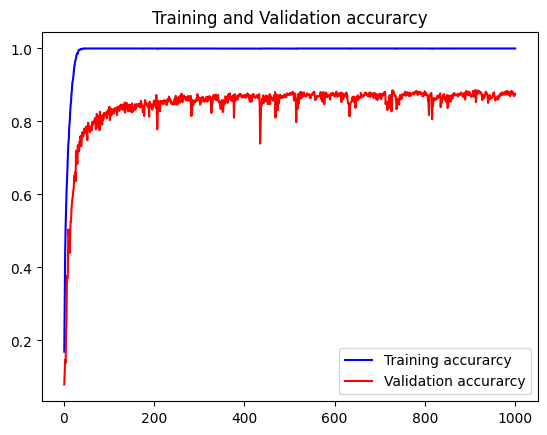

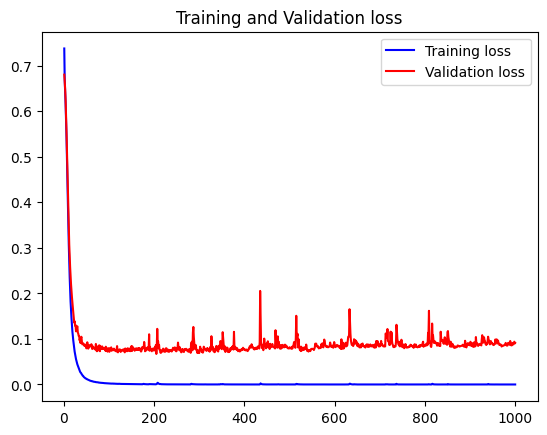

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Classiication report and Confusion matrix to analyse models performance

In [ ]:

y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

28/28 [==============================] - 1s 19ms/step
[[56  0  3  1  0  1  0  1  0  3  0  0  1  0  0]
 [ 1 58  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0 72  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  2 62  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 23  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0 58  1  0  0  0  0  1  2  0  0]
 [ 0  0  0  3  0  3 41  3  1  0  1  3  0  1  0]
 [ 1  0  2  8  0  0  4 45  1  0  0  0  1  0  2]
 [ 1  0  0  1  0  0  3  0 53  2  1  0  0  0  1]
 [ 2  0  0  5  1  1  1  2  4 35  3  1  0  2  1]
 [ 0  0  0  0  0  0  0  0  0  0 47  4  1  0  0]
 [ 0  0  0  4  0  0  2  0  0  0  3 41  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 44  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 57  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 71]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        66
           1       1.00      0.97      0.98        60
           2       0.91      0.97      0.94        74
           3       0.71      0.94      0.81        66
           4       0.96      0.88      0.92        26
           5       0.92      0.94      0.93        62
           6       0.75      0.73      0.74        56
           7       0.88      0.70      0.78        64
           8       0.88      0.85      0.87        62
           9       0.88      0.60      0.71        58
          10       0.82      0.90      0.86        52
          11       0.82      0.80      0.81        51
          12       0.88      0.98      0.93        45
          13       0.95      0.98      0.97        58
          14       0.93      1.00      0.97        71

    accuracy                           0.88       871
   macro avg       0.88      0.87      0.87       871
weighted avg       0.88   

## Saving the mode and converting it to a TenserFlow lite model

In [ ]:
model.save('densenet')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("densenet")
tflite_model = converter.convert()


with open("Densenet.tflite", "wb") as f:
    f.write(tflite_model)

## Predicting images via the model

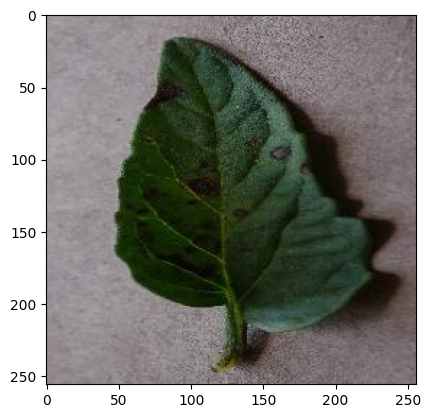

In [ ]:
imagepath = imread("/content/drive/MyDrive/plantdetection/Copy of 04ddbde3-d33c-42bf-b849-dad24d64fd6f___RS_Erly.B 7664.JPG")
image = imread("/content/drive/MyDrive/plantdetection/Copy of 04ddbde3-d33c-42bf-b849-dad24d64fd6f___RS_Erly.B 7664.JPG")
image = cv2.resize(image,(256,256))
imagepath = cv2.resize(imagepath,(256,256))
image = np.array(image/255)
image = image.reshape(-1,256,256,3)
plt.imshow(imagepath)

In [ ]:
classification_result = model.predict(image)
print(classification_result)

1/1 [==============================] - 0s 22ms/step
[[2.2715651e-07 4.4368496e-09 1.0956093e-09 1.3953871e-09 7.7496259e-11
  1.2206959e-09 9.9974912e-01 1.2654370e-07 4.6795735e-06 1.0962375e-07
  3.7536339e-11 1.7486160e-09 2.4568191e-04 2.3167399e-08 2.5843820e-08]]


In [ ]:
print(lb.classes_[(classification_result.argmax())])

Tomato_Early_blight


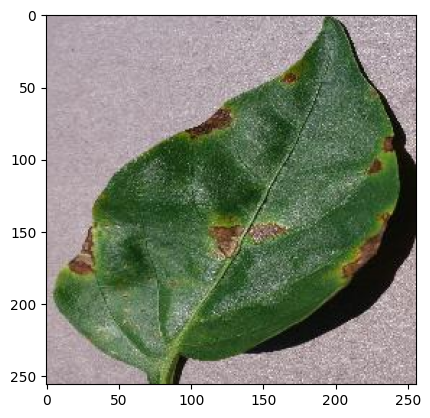

In [ ]:
imagepath = imread("/content/drive/MyDrive/plantdetection/024623ab-be81-4d99-a653-c3be1495ce8e___JR_B.Spot 8889.jpg")
image = imread("/content/drive/MyDrive/plantdetection/024623ab-be81-4d99-a653-c3be1495ce8e___JR_B.Spot 8889.jpg")
image = cv2.resize(image,(256,256))
imagepath = cv2.resize(imagepath,(256,256))
image = np.array(image/255)
image = image.reshape(-1,256,256,3)
plt.imshow(imagepath)

In [ ]:
classification_result = model.predict(image)
print(classification_result)

1/1 [==============================] - 0s 20ms/step
[[2.2489564e-08 9.9999976e-01 2.9580473e-08 5.6387517e-13 1.4283661e-07
  4.7032822e-09 9.1204653e-09 7.6672435e-10 1.0339512e-08 2.1222709e-08
  1.0196666e-11 6.2587616e-11 7.5621109e-09 3.8639492e-08 9.6481667e-10]]


In [ ]:
print(lb.classes_[(classification_result.argmax())])

Pepper__bell___healthy
